In [278]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
%matplotlib inline
from decimal import *
getcontext().prec = 6

matplotlib.rcParams.update({'font.size': 5, 'lines.linewidth': 0.5, 'figure.dpi': 300})


In [2]:
import sys
sys.path.insert(1, './backtesting.py')

from backtesting import Backtest, Strategy
from backtesting.lib import crossover


/Users/johnsmith/quant/pk-crypto-tools/./backtesting.py/backtesting/_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
df = pd.read_json(r'./freq-user-data/data/binance/BTC_USDT-5m.json').dropna()
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

df['date'] = pd.to_datetime(df['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(df["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
df = df.sort_index()

In [4]:
# ddf.iloc[-100:]

In [179]:
# pd.Timestamp('now').floor('D') + pd.Timedelta(-7, unit='D')

# start_time = datetime(2021,5,1)

start_time = pd.Timestamp('now') + pd.Timedelta(-20, unit='W')
# start_time
ddf = df.loc[df.index >= start_time].copy()
# ddf = df.loc[df['time'] >= start_time]
# ddf

# ddf = ddf.resample('5Min').agg(
#     OrderedDict([
#         ('open', 'first'),
#         ('high', 'max'),
#         ('low', 'min'),
#         ('close', 'last'),
#         ('volume', 'sum'),
#     ])
# ).dropna()

# ema = ddf.close.ewm(span=50,min_periods=0,adjust=False,ignore_na=False).mean()
# detrended = ddf.close - ddf.ema

ddf['lret'] = ddf.close.apply(np.log).diff(1).fillna(0)
ddf['cumlret'] = ddf.lret.cumsum()



In [279]:
fee:float = 0.001
capital = 10000
risk_per_trade = 0.01
dlen = len(ddf)

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    # wsize = pow(2,sl_n2.value)
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

wdg_bbma = widgets.IntText(value=50,step=3,description='bbma:',disabled=False,continuous_update=False)
wdg_bbstn = widgets.IntText(value=50,step=3,description='bbstn:',disabled=False,continuous_update=False)
wdg_bbstd = widgets.FloatText(value=3,step=0.1,description='bbstd:',disabled=False,continuous_update=False)

wdg_adxn = widgets.IntText(value=50, step=2, description='adxn:',disabled=False,continuous_update=False)
wdg_adxdiff = widgets.IntText(value=50, step=2, description='adxdiff:',disabled=False,continuous_update=False)
wdg_adxtr = widgets.IntText(value=25,step=2,description='adxt:',disabled=False,continuous_update=False)
wdg_adxmp = widgets.IntText(value=10, step=2, description='adxmp:',disabled=False,continuous_update=False)
wdg_adxmn = widgets.IntText(value=0, step=2, description='adxmn:',disabled=False,continuous_update=False)

# wdg_dmper = widgets.IntText(value=14,description='dmper:',disabled=False,continuous_update=False)
# wdg_dmtr = widgets.IntText(value=-200,description='dmtr:',disabled=False,continuous_update=False)

# wdg_rsiper = widgets.IntText(value=14,description='rsiper:',disabled=False,continuous_update=False)
# wdg_rsitr = widgets.IntText(value=-200,description='rsitr:',disabled=False,continuous_update=False)

# wdg_krn = widgets.FloatText(value=1,step=0.25,description='krn:',disabled=False,continuous_update=False)
# wdg_krpow = widgets.FloatText(value=1, step=0.05,description='krpow:',disabled=False,continuous_update=False)
# wdg_krstart = widgets.FloatText(value=1, step=1/6.,description='krstrt:',disabled=False,continuous_update=False)
# wdg_krend = widgets.FloatText(value=2, step=1/6.,description='krend:',disabled=False,continuous_update=False)
# wdg_krflip = widgets.Checkbox(value=False,description='krflip:',disabled=False,continuous_update=False)
# wdg_krflipy = widgets.Checkbox(value=False,description='krflipy:',disabled=False,continuous_update=False)
# wdg_cnv = FloatRangeSlider(description="cnv", min=-1, step=0.005, max=1,value=[0,0.1],continuous_update=False)

wdg_stoploss = FloatText(description="sl", min=-0.05, step=0.001, max=0, value=-2)
wdg_takeprofit = FloatText(description="tp", min=0, step=0.001, max=0.1, value=0.02)


# slXrr = FloatSlider(description="xrr", min=1, step=0.2, max=20, value=2)

ui = widgets.VBox([
    widgets.HBox([sl_n2, sl_w, wdg_stoploss, wdg_takeprofit]),
    widgets.HBox([wdg_bbma, wdg_bbstn, wdg_bbstd]),
    widgets.HBox([wdg_adxn, wdg_adxtr, wdg_adxdiff, wdg_adxmn, wdg_adxmp])
    # widgets.HBox([wdg_dmper, wdg_dmtr])
    # widgets.HBox([wdg_krn, wdg_krstart, wdg_krend, wdg_krpow, wdg_krflip, wdg_krflipy, wdg_cnv])
    # widgets.HBox([slTrailingStopLoss, slStopLoss, slTakeProfit, slXrr]),
#     widgets.HBox([slStK, slStD, slStSm, slStT])
])


wst = wed = wsz = buy_sig = g_buy_sig_cum = buy_cond = False
sell_cond = sell_sig = buy_sig_ind = sell_sig_ind = False
wdf = wadf = False
position_groups = positions_start_row = positions_end_row =  positions_min_posret =  positions_max_posret = False
# , krn, krstart, krend, krpow, krflip, krflipy, cnv
# , dmper, dmtr
# , rsiper, rsitr
def printer(w2log, w, stoploss, takeprofit, bbma, bbstn, bbstd, adxn, adxtr, adxdiff, adxmp, adxmn):

    global wst, wed, wsz, wdf, wadf

    pars = {k: v.value for k, v in dvals.items()}
    with open(f'strat-params-bbands-convol.json', "w") as f: f.write(json.dumps(pars)) 
    
    # krnn = floor(krn * 60)
    # krx = np.linspace(krstart, krend, krnn)
    # kry = krx

    # kry = np.tan(kry)
    # kry = np.sin(kry)
    # kry = np.power(kry , krpow)
    # if krflip: kry = np.flipud(kry)
    # if krflipy: kry = -(kry)
    # kry = kry - np.mean(kry)
    

    # ddf['adx'] = talib.ADX(ddf.high, ddf.low, ddf.close, timeperiod=adxn)    
    # ddf['minus_di'] = talib.MINUS_DI(ddf.high, ddf.low, ddf.close, timeperiod=adxn)
    # ddf['plus_di'] = talib.PLUS_DI(ddf.high, ddf.low, ddf.close, timeperiod=adxn)
    # ddf['di_diff'] = ddf.plus_di.values - ddf.minus_di.values
    # ddf['adx_dur'] = ddf.di_diff.rolling(adxdurn).min()
    # ddf['abv_bbma'] = (ddf.close - ddf.bb_middle) / ddf.bb_middle
    # ddf['cum_abv'] = ddf.abv_bbma.rolling(mmper).mean()

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)

    wdf['bb_middle'] = wdf.close.ewm(span=bbma,min_periods=0,adjust=False,ignore_na=False).mean()
    wdf['bb_std'] = wdf.close.rolling(bbstn).std()
    wdf['bb_std_bw'] = wdf.bb_std * bbstd
    wdf['bb_lower'] = wdf['bb_middle'] - wdf.bb_std_bw
    wdf['bb_upper'] = wdf['bb_middle'] + wdf.bb_std_bw
    wdf["bb_percent"] = (
        (wdf["close"] - wdf["bb_lower"]) /
        (wdf["bb_upper"] - wdf["bb_lower"])
    )
    wdf["bb_width"] = (
        (wdf["bb_upper"] - wdf["bb_lower"]) / wdf["bb_middle"]
    )

    wadf = ta.adx(wdf.high, wdf.low, wdf.close, length=adxn, lensig=None, mamode=None, scalar=None, drift=None, offset=None)
    wadf.columns = ['adx','dmp','dmn']
    wadf['dm_diff'] = wadf['dmp'].values - wadf['dmn'].values
    # wadf.dm_diff.fillna(0)
    # wadf['adx_dur'] = wadf.dm_diff.rolling(adxdurn).min() #.fillna(0)

    # wdf = wdf.join(wadf)

    buy_cond = (
        (wdf.open <= wdf.bb_lower) &
        (wadf.adx >= adxtr) & 
        (wadf.dm_diff > adxdiff) & 
        (wadf.dmp >= adxmp) & 
        (wadf.dmn <= adxmn)
    )
    # buy_cond = buy_cond

    buy_cond_vals = buy_cond.shift(fill_value=False).values
    open_price_arr = wdf.open.values
    high_price_arr = wdf.high.values
    low_price_arr = wdf.low.values

    enter_sig_arr = np.full(wlen, False)
    exit_sig_arr = np.full(wlen, False)
    in_pos_arr = np.full(wlen, 0)

    # enter_price_arr = numpy.full(wlen, 0)
    # exit_price_arr = numpy.full(wlen, 0)
    roi_ret_arr = np.full(wlen, 0.)

    in_pos = False
    enter_price = 0.
    stop_price = 0
    roi_price = 0.
    for i in range(max(bbma, bbstn), wlen):
        in_pos_arr[i] = in_pos
        if in_pos:
            exit_price: float = 0
            if low_price_arr[i] <= stop_price:
                exit_price = stop_price
            elif open_price_arr[i] - roi_price > 0:            
                exit_price = roi_price 
            
            if exit_price != 0:
                exit_sig_arr[i] = True
                ret = exit_price - enter_price 
                roi_ret_arr[i] = ret / enter_price - 2 * fee
                in_pos = False

        else:
            if buy_cond_vals[i]:
                in_pos = True
                enter_price = open_price_arr[i]
                # size = capital * risk_per_trade
                # pos = size/enter_price
                enter_sig_arr[i] = True
                stop_price = open_price_arr[i] * (1 + stoploss)
                roi_price = open_price_arr[i] * (1 + takeprofit)
                # print("enter: {}, {}, {}".format(enter_price, stop_price, roi_price))
                in_pos_arr[i] = in_pos
            

    wdf['enter_sig'] = enter_sig_arr
    wdf['exit_sig'] = exit_sig_arr
    
    wdf['roi_ret'] = roi_ret_arr
    wdf['roi_cum_ret'] = wdf['roi_ret'].cumsum()

    # wdf['enter_price'] = enter_price_arr
    # wdf['exit_price'] = exit_price_arr
    # wdf['roi_ret'] = wdf.exit_price - wdf.exit_price
    # wdf['roi_ret_perc'] = wdf.roi_ret / wdf.enter_price
    # wdf['roi_cum_ret_perc'] = wdf.roi_ret_perc.cumsum()

    wdf['in_pos'] = in_pos_arr

    wdf['poslret'] = wdf.lret * wdf.in_pos.astype(int)
    wdf.loc[wdf.enter_sig, 'poslret'] = 0
    wdf.loc[wdf.enter_sig.shift(fill_value=False), 'poslret'] -= fee
    wdf.loc[wdf.exit_sig, 'poslret'] -= fee

    wdf['g_enter'] = wdf.enter_sig.cumsum()
    wdf['g_exit'] = wdf.enter_sig.cumsum()

    enter_sig_ind = wdf[wdf.enter_sig].index
    exit_sig_ind = wdf[wdf.exit_sig].index
    
    enter_groups = wdf.groupby(wdf.g_enter, sort=False)
    exit_groups = wdf.groupby(wdf.g_enter, sort=False)
    wdf['poscumlret'] = enter_groups.poslret.cumsum() * wdf.in_pos.astype(int)
    wdf['totcumlret'] = wdf.poslret.cumsum()


    # positions_start_row = enter_groups.head(1)
    # positions_end_row = exit_groups.head(1)
    # positions_min_poscumlret = exit_groups.poscumlret.min()
    # positions_max_poscumlret = exit_groups.poscumlret.max()

    # wdf['poscumplret'] = wdf.totcumlret * wdf.in_pos.astype(int)

    wexits = wdf.loc[exit_sig_ind]
    wprofits = wexits[wexits.roi_ret > 0]
    wlosses = wexits[wexits.roi_ret <= 0]

    
#     with open(f'./strategy-results/{datetime.now():strat_%Y-%m-%d}.log', "a") as f: 
#         f.write(json.dumps(dict({   
#             "dt": f'{datetime.now():%Y-%m-%d %HH:%MM:%SS}',
#             "period_start": f'{ddf.index[0]}',
#             "period_end": f'{ddf.index[-1]}',
#             "params": dict({ 'sl': sl, 'ts': ts, 'tp': tp, 'ma1n': ma1n, 'ma2n': ma2n, 'ma1c': ma1c, 'ma2c': ma2c, 'trn': trn, 'mrn': mrn, 'xrr': xrr
# #                         'std': std, 'stk': stk, 'stsm': stsm, 'stt': slStT.value
#                            }),
#             "strategy": "2EMASTH",
#             "profit": floor(100* (trades.iloc[-1].cap / capital - 1)) if len(trades.index) else 0. 
#         })
#     )); f.write("\n");
    
    
    plt.close("all")
    fig = plt.figure(constrained_layout=True,figsize=(16,5))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[3,1])

    gs00 = gs0[0,0].subgridspec(4, 1, height_ratios=[2,2,1,1])
    gs01 = gs0[0,1].subgridspec(4, 1)

    ax001 = fig.add_subplot(gs00[0,0])
    ax002 = fig.add_subplot(gs00[1,0], sharex=ax001)
    ax003 = fig.add_subplot(gs00[2,0], sharex=ax001)
    ax004 = fig.add_subplot(gs00[3,0], sharex=ax001)

    ax101 = fig.add_subplot(gs01[0,0])
    ax102 = fig.add_subplot(gs01[1,0])
    ax103 = fig.add_subplot(gs01[2,0])
    ax104 = fig.add_subplot(gs01[3,0])

    wclose_min = wdf.close.min()
    wclose_max = wdf.close.max()

    ax001.plot(wdf['close'])
    ax001.plot(wdf['low'], lw=0.5)
    ax001.plot(wdf['high'], lw=0.5)
    ax001.plot(wdf.bb_middle)
    ax001.plot(wdf.bb_lower)
    ax001.plot(wdf.bb_upper)
    if len(enter_sig_ind): ax001.vlines(enter_sig_ind, wclose_min, wclose_max, lw=1, color="b")
    if len(wprofits) > 0: ax001.vlines(wprofits.index, wclose_min , wclose_max, lw=1, color="g", linestyle='--')
    if len(wlosses) > 0: ax001.vlines(wlosses.index, wclose_min , wclose_max, lw=1, color="r", linestyle='--')
    
    ax001.fill_between(wdf.index, wdf.bb_middle*0.99, wdf.bb_middle*1.01, alpha=0.15)

    min_poscumlret = wdf.poscumlret.min()
    max_poscumlret = wdf.poscumlret.max()
    ax002.plot(wdf.poscumlret)
    # ax002.plot(wdf.postradecumlret, linestyle='dotted')
    ax002.axhline()
    ax002.axhline(y=stoploss, color='b', linestyle='dotted')
    ax002.axhline(y=takeprofit, color='b', linestyle='dotted')
    ax002.vlines(enter_sig_ind, min_poscumlret, max_poscumlret, lw=0.5, color="b")
    if len(wprofits) > 0: ax002.vlines(wprofits.index, min_poscumlret , max_poscumlret, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax002.vlines(wlosses.index, min_poscumlret , max_poscumlret, lw=0.5, color="r", linestyle='--')
    # ax002.hlines(positions_min_poscumlret,positions_start_row.index, positions_end_row.index, color='r', linestyle='--')
    # ax002.hlines(positions_max_poscumlret,positions_start_row.index, positions_end_row.index, color='g', linestyle='--')

    # min_totcumlret = wdf.totcumlret.min()
    # max_totcumlret = wdf.totcumlret.max()
    # ax003.plot(wdf.totcumlret, color='b', lw=0.5)
    # ax003.axhline()
    # ax003.axhline(y=stoploss, color='b', linestyle='dotted')
    # ax003.axhline(y=takeprofit, color='b', linestyle='dotted')
    # ax003.vlines(enter_sig_ind, min_totcumlret, max_totcumlret, lw=0.5, color="b")
    # if len(wprofits) > 0: ax003.vlines(wprofits.index, min_totcumlret , max_totcumlret, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax003.vlines(wlosses.index, min_totcumlret , max_totcumlret, lw=0.5, color="r", linestyle='--')

    min_adx = min(wadf.adx.min(),wadf.dmp.min(),wadf.dmn.min(),wadf.dm_diff.min())
    max_adx = max(wadf.adx.max(),wadf.dmp.max(),wadf.dmn.max(),wadf.dm_diff.max())
    ax003.plot(wadf.adx)
    ax003.plot(wadf.dmp, color='g')
    ax003.plot(wadf.dmn, color='r')
    ax003.plot(wadf.dm_diff, color='black', linestyle='dotted')
    ax003.axhline(y=20)
    ax003.vlines(enter_sig_ind, min_adx, max_adx, lw=0.5, color="b")
    if len(wprofits) > 0: ax003.vlines(wprofits.index, min_adx, max_adx, lw=0.5, color="g", linestyle='--')
    if len(wlosses) > 0: ax003.vlines(wlosses.index, min_adx, max_adx, lw=0.5, color="r", linestyle='--')
    
    # min_roi_cum_ret_perc = wdf.roi_cum_ret_perc.min()
    # max_roi_cum_ret_perc = wdf.roi_cum_ret_perc.max()
    ax004.plot(wdf.roi_cum_ret)
    ax004.axhline()
    # ax004.axhline(y=50)
    # ax004.axhline(y=20, linestyle='dotted')
    # ax004.axhline(y=80, linestyle='dotted')
    # ax004.vlines(buy_sig_ind, min_roi_cum_ret_perc, max_roi_cum_ret_perc, lw=0.5, color="b")
    # if len(wprofits) > 0: ax004.vlines(wprofits.index, min_roi_cum_ret_perc , max_roi_cum_ret_perc, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax004.vlines(wlosses.index, min_roi_cum_ret_perc , max_roi_cum_ret_perc, lw=0.5, color="r", linestyle='--')

    # conv1_min = wdf.conv1.min()
    # conv1_max = wdf.conv1.max()
    # ax002.plot(wdf.conv1)
    # ax002.axhline(color='b', linestyle='--')
    # ax002.vlines(buy_sig_ind, conv1_min, conv1_max, lw=0.5, color="b")
    # if len(wprofits) > 0: ax002.vlines(wprofits.index, conv1_min , conv1_max, lw=0.5, color="g", linestyle='--')
    # if len(wlosses) > 0: ax002.vlines(wlosses.index, conv1_min , conv1_max, lw=0.5, color="r", linestyle='--')

    # ax101.plot(krx, kry)
    # ax101.axhline(color='b', linestyle='--')

    # ax102.plot(tret)
    # ax102.axhline(color='b', linestyle='--')
    
    plt.show()
    # print(pf.stats())
    # print(pf.returns_stats())
    

dvals = {"w2log":sl_n2, "w":sl_w, "stoploss": wdg_stoploss, "takeprofit": wdg_takeprofit,
    'bbma': wdg_bbma, 'bbstn': wdg_bbstn, 'bbstd': wdg_bbstd,
    'adxn': wdg_adxn, 'adxtr': wdg_adxtr, 'adxdiff': wdg_adxdiff, 'adxmp': wdg_adxmp, 'adxmn': wdg_adxmn,
    # 'dmper': wdg_dmper, 'dmtr': wdg_dmtr
    # 'krn': wdg_krn, 'krstart': wdg_krstart, 'krend': wdg_krend, 'krpow': wdg_krpow, 'krflip': wdg_krflip, 'krflipy': wdg_krflipy, 'cnv': wdg_cnv
    }


with open('strat-params-bbands-convol.json') as f: 
    js = json.loads(f.read());
    for k, v in dvals.items(): 
        if k in js: v.value=js[k] ;
                                        

out = widgets.interactive_output(printer, dvals)
display(ui, out)



Output()

In [181]:
import pyperclip
# pyperclip.copy('The text to be copied to the clipboard.')
# spam = pyperclip.paste()
timerange = "{}-{}".format(floor(wdf.iloc[0].timestamp/1000), floor(wdf.iloc[-1].timestamp/1000))
cmds = ['freqtrade backtesting -c freqtrade-config.json --userdir freq-user-data --strategy BBandsStrategy --timeframe 1m --timerange {}'.format(timerange) , 
'freqtrade plot-dataframe  -c freqtrade-config.json -s BBandsStrategy --timerange {}'.format(timerange), 
'freqtrade plot-profit  -c freqtrade-config.json -s BBandsStrategy --timerange {}'.format(timerange)]
pyperclip.copy("\n".join(cmds))

In [368]:
fparams = 'strat-params-bbands-stats.json'

sl_n2= IntSlider(description="n2", min=0, max=ceil(log(dlen, 2.0)+1), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=ceil(dlen/pow(2,sl_n2.value-1)-1), step=1, value=1)
def update_sl_w_range(*args):
    sl_w.max = ceil(dlen/pow(2,sl_n2.value-1)-1)
sl_n2.observe(update_sl_w_range, 'value')

wdg_wdelta = widgets.FloatText(value=-2.5,step=0.25,description='wdelta:',disabled=False,continuous_update=False)


wdg_bbma = widgets.IntText(value=50,step=3,description='bbma:',disabled=False,continuous_update=False)
wdg_bbstn = widgets.IntText(value=50,step=3,description='bbstn:',disabled=False,continuous_update=False)
wdg_bbstd = widgets.FloatText(value=3,step=0.1,description='bbstd:',disabled=False,continuous_update=False)
wdg_bbwidth = widgets.FloatText(value=3,step=0.1,description='bbwidth:',disabled=False,continuous_update=False)
wdg_bbpercent = widgets.FloatText(value=3,step=0.1,description='bbperc:',disabled=False,continuous_update=False)

wdg_adxn = widgets.IntText(value=50, step=2, description='adxn:',disabled=False,continuous_update=False)
wdg_adxdiff = widgets.IntText(value=50, step=2, description='adxdiff:',disabled=False,continuous_update=False)
wdg_adxtr = widgets.IntText(value=25,step=2,description='adxt:',disabled=False,continuous_update=False)
wdg_adxmp = widgets.IntText(value=10, step=2, description='adxmp:',disabled=False,continuous_update=False)
wdg_adxmn = widgets.IntText(value=0, step=2, description='adxmn:',disabled=False,continuous_update=False)

ui = widgets.VBox([
    widgets.HBox([sl_n2, sl_w, wdg_wdelta]),
    widgets.HBox([wdg_bbma, wdg_bbstn, wdg_bbstd, wdg_bbwidth, wdg_bbpercent]),
    widgets.HBox([wdg_adxn, wdg_adxtr, wdg_adxdiff, wdg_adxmn, wdg_adxmp])
])

axs = False
fcumret = posgroups = False
wdf = wadf = posdf = pgheads = phf = False
def stats_printer(w2log, w, wdelta, bbma, bbstn, bbstd, bbpercent, bbwidth, adxn, adxtr, adxdiff, adxmp, adxmn):

    global wst, wed, wsz, wdf, wadf, axs, fcumret, posdf, posgroups, phf

    pars = {k: v.value for k, v in dvals.items()}
    with open(fparams, "w") as f: f.write(json.dumps(pars)) 

    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    wdf = ddf.iloc[wst:wed,:].copy()    
    wlen = len(wdf)


    wdf['lret'] = ddf.close.apply(np.log).diff(1).fillna(0)

    wdf['bb_middle'] = wdf.close.ewm(span=bbma,min_periods=0,adjust=False,ignore_na=False).mean()
    wdf['bb_std'] = wdf.close.rolling(bbstn).std()
    wdf['bb_std_bw'] = wdf.bb_std * bbstd
    wdf['bb_lower'] = wdf['bb_middle'] - wdf.bb_std_bw
    wdf['bb_upper'] = wdf['bb_middle'] + wdf.bb_std_bw

    wdf["bb_percent"] = (wdf["close"] - wdf["bb_lower"]) / (wdf["bb_upper"] - wdf["bb_lower"]) * 100
    wdf["bb_width"] = (wdf["bb_upper"] - wdf["bb_lower"]) / wdf["bb_middle"] * 100

    wadf = ta.adx(wdf.high, wdf.low, wdf.close, length=adxn, lensig=None, mamode=None, scalar=None, drift=None, offset=None)
    wadf.columns = ['adx','dmp','dmn']

    wadf['dm_diff'] = wadf['dmp'].values - wadf['dmn'].values

    wdf = wdf.join(wadf)

    wdf_freq = pd.Timedelta(5, unit='m')
    pdelta = pd.Timedelta(wdelta, unit="h")
    pdelta_ticks = floor(pdelta / wdf_freq)

    wdf['fucumret'] = wdf.lret.rolling(pdelta).sum().shift(-pdelta_ticks)
    wdf['overval'] = (wdf.close - wdf.bb_middle) / wdf.bb_std


    buy_cond = (
        (wdf.open <= wdf.bb_lower) &
        (wadf.adx >= adxtr) & 
        (wadf.dm_diff > adxdiff) & 
        (wadf.dmp >= adxmp) & 
        (wadf.dmn <= adxmn) #& 
        # (wdf.bb_width >= bbwidth) & 
        # (wdf.bb_percent >= bbpercent)
    )

    buy_sig = buy_cond & (~buy_cond).shift(fill_value=False)
    # buy_sig = buy_sig.shift(fill_value=False)

    wdf['g_buy'] = buy_sig.cumsum()
    posgroups = wdf.groupby(wdf.g_buy)

    phf = posgroups.head(1)
    wdf.loc[phf.index, 'lret'] = 0

    wdf['poscumret'] = posgroups.lret.cumsum()
    wdf.loc[phf.index, 'ptret'] = posgroups.poscumret.tail(1).values
    wdf.loc[phf.index, 'minret'] = posgroups.poscumret.min().values
    wdf.loc[phf.index, 'maxret'] = posgroups.poscumret.max().values
    phf = posgroups.head(1)


    # wdf[~buy_cond].fucumret = 0
    bwdf = wdf[buy_sig]
    bwadf = wadf[buy_sig]
    
    plt.close("all")
    s=0.1
    fig, axs = plt.subplots(4, 4, constrained_layout=True, figsize=(12,5))
    axsf = axs.flat
    for axi in range(1, len(axsf)):
        ax = axsf[axi]
        ax.axhline(color='b')

    axs[0,0].set_title('price')
    axs[0,0].plot(wdf.close)
    axs[0,0].plot(wdf.bb_middle)
    axs[0,0].plot(wdf.bb_lower)

    axs[0,1].set_title('adx/ret')
    axs[0,1].scatter(phf.adx.values, phf.fucumret.values, s=s)
    axs[0,1].scatter(phf.adx.values, phf.minret.values, s=s, color='r')
    axs[0,1].scatter(phf.adx.values, phf.maxret.values, s=s, color='g')

    axs[0,2].set_title('dmp/ret')
    axs[0,2].scatter(phf.dmp.values, phf.fucumret.values, s=s)
    axs[0,2].scatter(phf.dmp.values, phf.minret.values, s=s, color='r')
    axs[0,2].scatter(phf.dmp.values, phf.maxret.values, s=s, color='g')
    
    axs[0,3].set_title('dmn/ret')
    axs[0,3].scatter(phf.dmn.values, phf.fucumret.values, s=s)
    axs[0,3].scatter(phf.dmn.values, phf.minret.values, s=s, color='r')
    axs[0,3].scatter(phf.dmn.values, phf.maxret.values, s=s, color='g')


    # axs[1,0].set_title('dm_diff/ret')
    # # axs[1,0].scatter(bwadf.dm_diff.values, phf.fucumret.values, s=0.1)
    # axs[1,0].scatter(phf.dm_diff.values, phf.minret.values, s=0.05, color='r')
    # axs[1,0].scatter(phf.dm_diff.values, phf.maxret.values, s=0.05, color='g')

    axs[1,1].set_title('overval/ret')
    axs[1,1].scatter(phf.overval.values, phf.fucumret.values, s=s)
    axs[1,1].scatter(phf.overval.values, phf.minret.values, s=s, color='r')
    axs[1,1].scatter(phf.overval.values, phf.maxret.values, s=s, color='g')

    axs[1,2].set_title('bb_percent/ret')
    axs[1,2].scatter(phf.bb_percent.values, phf.fucumret.values, s=s)
    axs[1,2].scatter(phf.bb_percent.values, phf.minret.values, s=s, color='r')
    axs[1,2].scatter(phf.bb_percent.values, phf.maxret.values, s=s, color='g')

    axs[1,3].set_title('bb_width/ret')
    axs[1,3].scatter(phf.bb_width.values, phf.fucumret.values, s=s)
    axs[1,3].scatter(phf.bb_width.values, phf.minret.values, s=s, color='r')
    axs[1,3].scatter(phf.bb_width.values, phf.maxret.values, s=s, color='g')


    axs[2,1].set_title('dm_diff/ret')
    axs[2,1].scatter(phf.dm_diff.values, phf.fucumret.values, s=s)
    axs[2,1].scatter(phf.dm_diff.values, phf.minret.values, s=s, color='r')
    axs[2,1].scatter(phf.dm_diff.values, phf.maxret.values, s=s, color='g')

    # axs[2,0].set_title('minret/maxret')
    # axs[2,0].scatter(-bwdf.minposcumret.values, bwdf.maxposcumret.values, s=0.1)

    # axs[1,2].scatter(wdf.bb_percent.values, fcumret.values, s=0.2)
    # axs[1,3].scatter(wdf.bb_width.values, fcumret.values, s=0.2)
    # for ax in axs.flat:
    #     ax.plot([1,2])
    
    plt.show()
    

dvals = {
    "w2log":sl_n2, "w":sl_w, 
    'bbma': wdg_bbma, 'bbstn': wdg_bbstn, 'bbstd': wdg_bbstd, 'bbpercent': wdg_bbpercent, 'bbwidth': wdg_bbwidth,
    'adxn': wdg_adxn, 'adxtr': wdg_adxtr, 'adxdiff': wdg_adxdiff, 'adxmp': wdg_adxmp, 'adxmn': wdg_adxmn, 
    'wdelta': wdg_wdelta,
    }
     

if os.path.isfile(fparams): 
    with open(fparams) as f: 
        js = json.loads(f.read());
        for k, v in dvals.items(): 
            if k in js: v.value=js[k] ;
                    
out = widgets.interactive_output(stats_printer, dvals)
display(ui, out)


Output()

In [344]:

wdf['poscumret'] = posgroups.lret.cumsum()
wdf.loc[pgheads.index, 'ptret'] = posgroups.poscumret.tail(1).values
wdf.loc[pgheads.index, 'minret'] = posgroups.poscumret.min().values
wdf.loc[pgheads.index, 'maxret'] = posgroups.poscumret.max().values
pgheads = posgroups.head(1)



In [353]:
wdf.join(wadf)

,timestamp,open,high,low,close,volume,date,lret,cumlret,bb_middle,...,overval,g_buy,poscumret,ptret,minret,maxret,adx,dmp,dmn,dm_diff
date,,,,,,,,,,,,,,,,,,,,,
2021-06-26 21:35:00,1624743300000,31169.99,31257.47,31148.55,31250.81,152.154576,2021-06-26 21:35:00,0.000000,-0.434857,31250.810000,...,NaN,0,0.000000,0.045628,-0.002576,0.067766,NaN,NaN,NaN,NaN
2021-06-26 21:40:00,1624743600000,31244.62,31246.51,31170.42,31170.42,111.811612,2021-06-26 21:40:00,-0.002576,-0.437432,31247.657451,...,NaN,0,-0.002576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:45:00,1624743900000,31170.43,31400.00,31165.00,31366.94,386.362089,2021-06-26 21:45:00,0.006285,-0.431148,31252.335198,...,NaN,0,0.003709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:50:00,1624744200000,31363.99,31374.14,31299.64,31332.63,131.614911,2021-06-26 21:50:00,-0.001094,-0.432242,31255.484014,...,NaN,0,0.002615,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-26 21:55:00,1624744500000,31332.62,31442.95,31319.32,31411.98,209.719376,2021-06-26 21:55:00,0.002529,-0.429713,31261.621111,...,NaN,0,0.005144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14 01:25:00,1626225900000,32366.52,32366.52,32299.76,32348.37,118.579079,2021-07-14 01:25:00,-0.000561,-0.400338,32523.705158,...,-1.219362,109,-0.009013,NaN,NaN,NaN,9.135885,16.523345,22.374446,-5.851101
2021-07-14 01:30:00,1626226200000,32348.36,32348.37,32265.00,32323.86,174.547413,2021-07-14 01:30:00,-0.000758,-0.401096,32515.868093,...,-1.282318,109,-0.009771,NaN,NaN,NaN,9.287289,16.293944,22.830026,-6.536082
2021-07-14 01:35:00,1626226500000,32323.86,32446.38,32320.00,32426.75,213.469862,2021-07-14 01:35:00,0.003178,-0.397918,32512.373266,...,-0.571006,109,-0.006593,NaN,NaN,NaN,9.311159,17.633627,21.762676,-4.129049


In [352]:
wadf

,adx,dmp,dmn,dm_diff
date,,,,
2021-06-26 21:35:00,NaN,NaN,NaN,NaN
2021-06-26 21:40:00,NaN,NaN,NaN,NaN
2021-06-26 21:45:00,NaN,NaN,NaN,NaN
2021-06-26 21:50:00,NaN,NaN,NaN,NaN
2021-06-26 21:55:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-07-14 01:25:00,9.135885,16.523345,22.374446,-5.851101
2021-07-14 01:30:00,9.287289,16.293944,22.830026,-6.536082
2021-07-14 01:35:00,9.311159,17.633627,21.762676,-4.129049


In [868]:

wdg_krn = widgets.IntText(value=50,description='krn:',disabled=False)
wdg_krpow = widgets.FloatText(value=1, step=0.05,description='krpow:',disabled=False)
wdg_krstart = widgets.FloatText(value=0, step=1/6.,description='krstrt:',disabled=False)
wdg_krend = widgets.FloatText(value=2, step=1/6.,description='krend:',disabled=False)
wdg_krflip = widgets.Checkbox(value=False,description='krflip:',disabled=False)
wdg_krflipy = widgets.Checkbox(value=False,description='krflipy:',disabled=False)
ui = widgets.VBox([
        widgets.HBox([wdg_krn, wdg_krstart, wdg_krend, wdg_krpow]),
        widgets.HBox([wdg_krflip, wdg_krflipy])
    ])
kry = False
def inter_plot(krn, krstart, krend, krpow, krflip, krflipy):
    global kry

    with open(f'./strat-params-fn-convol.json', "w") as f: f.write(json.dumps({k: v.value for k, v in dvals.items()})) 
    plt.close("all")
    krx = np.linspace(krstart, krend, krn)
    kry = krx
   
    # kry = np.tan(kry)
    kry = np.sin(kry) #*pi
    kry = np.power(kry , krpow)
    kry = np.tan(kry)
    # kry = np.exp(kry)
    # kry = np.power(kry , krpow)
    # kry = np.arctan(kry)
    # kry = np.cos(kry)
    if krflip: kry = np.flipud(kry)
    if krflipy: kry = -(kry)
    kry = kry - np.mean(kry)
    
    
    fig, (ax1) = plt.subplots(1, 1,figsize=(2,0.5), sharex='col', gridspec_kw={'width_ratios': [1]})
    ax1.plot(krx, kry)
    # ax1.plot(krx, np.flipud(kry))

dvals = {'krn': wdg_krn, 'krstart': wdg_krstart, 'krend': wdg_krend, 'krpow': wdg_krpow,
    'krflip': wdg_krflip, 'krflipy': wdg_krflipy}


with open('./strat-params-fn-convol.json') as f: 
    js = json.loads(f.read());
    for k, v in dvals.items(): 
        if k in js: v.value=js[k] ;

out = widgets.interactive_output(inter_plot, dvals)
display(ui, out)


Output()

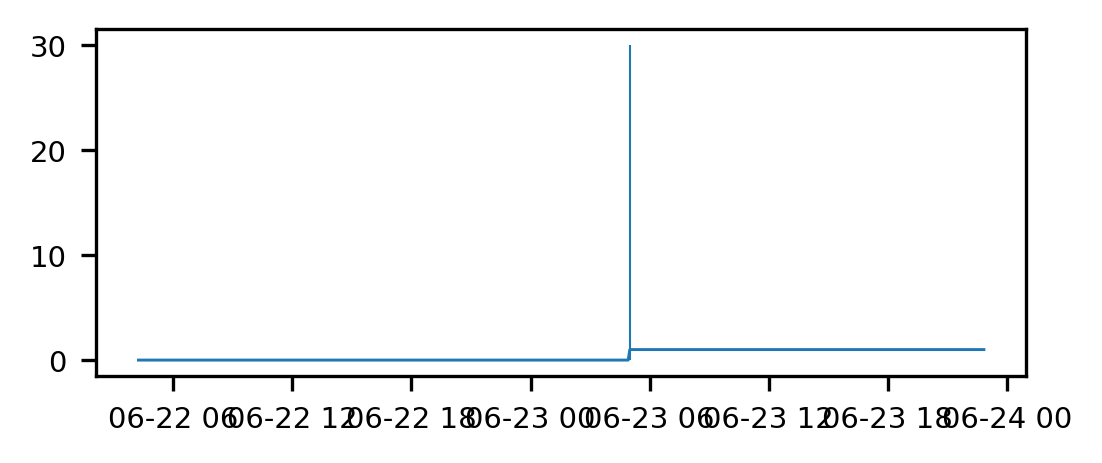

In [261]:
fig = plt.figure(figsize=(4,1.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(g_buy_sig_cum)
ax.vlines(wbsig.index, 0 , 30, lw=0.5)
# ax.plot(xdata2, ydata2, color='tab:orange')

